# 数据集简介

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from utils import ISIC2018Dataset, draw_samples

### 数据集特征
ISIC2018数据集先天的是一个类别不平衡的分类数据集。<br/>
在实验中，由于缺乏测试集的标签，因此我将训练集分出$\frac{1}{5}$作为测试集，验证集用来控制训练进程、选择最优模型。

<AxesSubplot:title={'center':'isic2018 training set with 8012 samples'}, xlabel='categories'>

<AxesSubplot:title={'center':'isic2018 validation set with 193 samples'}, xlabel='categories'>

<AxesSubplot:title={'center':'isic2018 testing set with 2003 samples'}, xlabel='categories'>

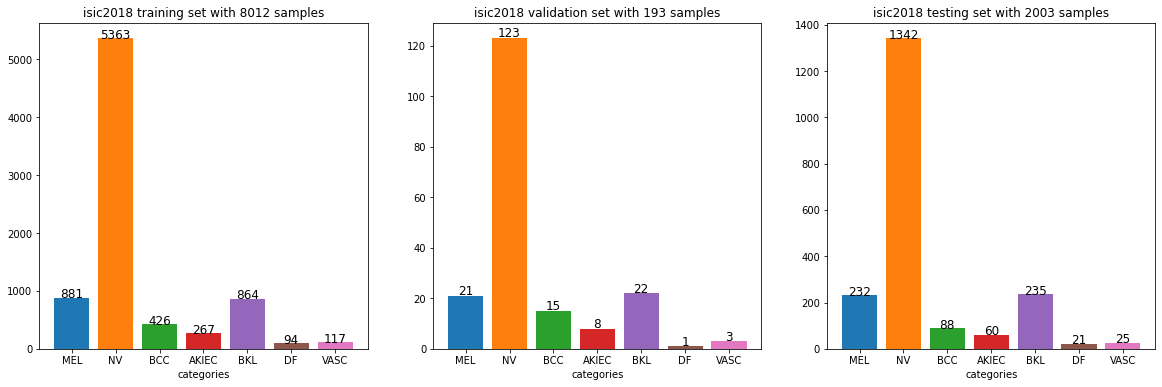

In [2]:
train_dataset = ISIC2018Dataset(
    csv_file_path='./data/ISIC2018/Train_GroundTruth.csv',
    img_dir='./data/ISIC2018/ISIC2018_Task3_Training_Input'
)
valid_dataset = ISIC2018Dataset(
    csv_file_path='./data/ISIC2018/ISIC2018_Task3_Validation_GroundTruth.csv',
    img_dir='./data/ISIC2018/ISIC2018_Task3_Validation_Input'
)
test_dataset = ISIC2018Dataset(
    csv_file_path='./data/ISIC2018/Test_GroundTruth.csv',
    img_dir='./data/ISIC2018/ISIC2018_Task3_Training_Input'
)

train_count = train_dataset.count_samples()
valid_count = valid_dataset.count_samples()
test_count = test_dataset.count_samples()

def draw_bar(ax, data, title):
    for i in range(len(data)):
        ax.bar(data[i][0], data[i][1])
        ax.text(data[i][0], data[i][1]+0.5, f"{data[i][1]}", ha='center', fontsize=12)
    ax.set_xlabel("categories")
    ax.set_title(title)
    return ax

fig, axes = plt.subplots(1, 3, facecolor='w', figsize=(20, 6))
axes = axes.flat
draw_bar(axes[0], train_count, f"isic2018 training set with {len(train_dataset)} samples")
draw_bar(axes[1], valid_count, f"isic2018 validation set with {len(valid_dataset)} samples")
draw_bar(axes[2], test_count, f"isic2018 testing set with {len(test_dataset)} samples")
plt.show()

ISIC是一个医学图像数据集，其最大的特征是具有类内差异性和类间相似性。

In [ ]:
images, labels = [], []
for cls in range(train_dataset.num_classes):
    img_idx = train_dataset.targets.index(cls)
    img, target  = train_dataset[img_idx]
    images.append(img)
    labels.append(train_dataset.target_to_label[target])

    img_idx = train_dataset.targets.index(cls, img_idx+1)
    img, target  = train_dataset[img_idx]
    images.append(img)
    labels.append(train_dataset.target_to_label[target])

fig, axes = draw_samples(images, labels, 7, 2)
plt.show()

### 数据预处理
在实验中，我对训练数据集采取了如下的数据增广操作
- 随机左右翻转
- 随机上下翻转
- 随机旋转[-30deg,  30deg]
- 随机裁剪出大小为[224, 224]区域
- 转换成PyTorch使用的tensor形式
- 应用正则化

对验证集
- 最小边放缩至224
- 中心裁剪大小为[224, 224]的区域
- 转换成PyTorch使用的tensor形式
- 应用正则化

在评估的时候，训练、验证、测试集都使用了第二种处理方式

In [ ]:

train_trans = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.4, 1), ratio=(3/4, 4/3)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_trans = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ISIC2018Dataset(
    csv_file_path='./data/ISIC2018/Train_GroundTruth.csv',
    img_dir='./data/ISIC2018/ISIC2018_Task3_Training_Input',
    transform=train_trans
)

valid_dataset = ISIC2018Dataset(
    csv_file_path='./data/ISIC2018/ISIC2018_Task3_Validation_GroundTruth.csv',
    img_dir='./data/ISIC2018/ISIC2018_Task3_Validation_Input',
    transform=test_trans
)

test_dataset = ISIC2018Dataset(
    csv_file_path='./data/ISIC2018/Test_GroundTruth.csv',
    img_dir='./data/ISIC2018/ISIC2018_Task3_Training_Input',
    transform=test_trans
)

train_iter = DataLoader(train_dataset,
                        batch_size=6)
valid_iter = DataLoader(valid_dataset,
                        batch_size=6)

images, labels = next(iter(train_iter))

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = [img.transpose((1, 2, 0)) for img in images.numpy()]
images = [np.clip(std*img+mean, 0, 1) for img in images]
labels = [train_dataset.target_to_label[i] for i in labels.numpy()]

fig, axes = draw_samples(images, labels, 3, 2, "train transform")
plt.show()

In [ ]:
images, labels = next(iter(valid_iter))

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = [img.transpose((1, 2, 0)) for img in images.numpy()]
images = [np.clip(std*img+mean, 0, 1) for img in images]
labels = [train_dataset.target_to_label[i] for i in labels.numpy()]

fig, axes = draw_samples(images, labels, 3, 2, "test transform")
plt.show()

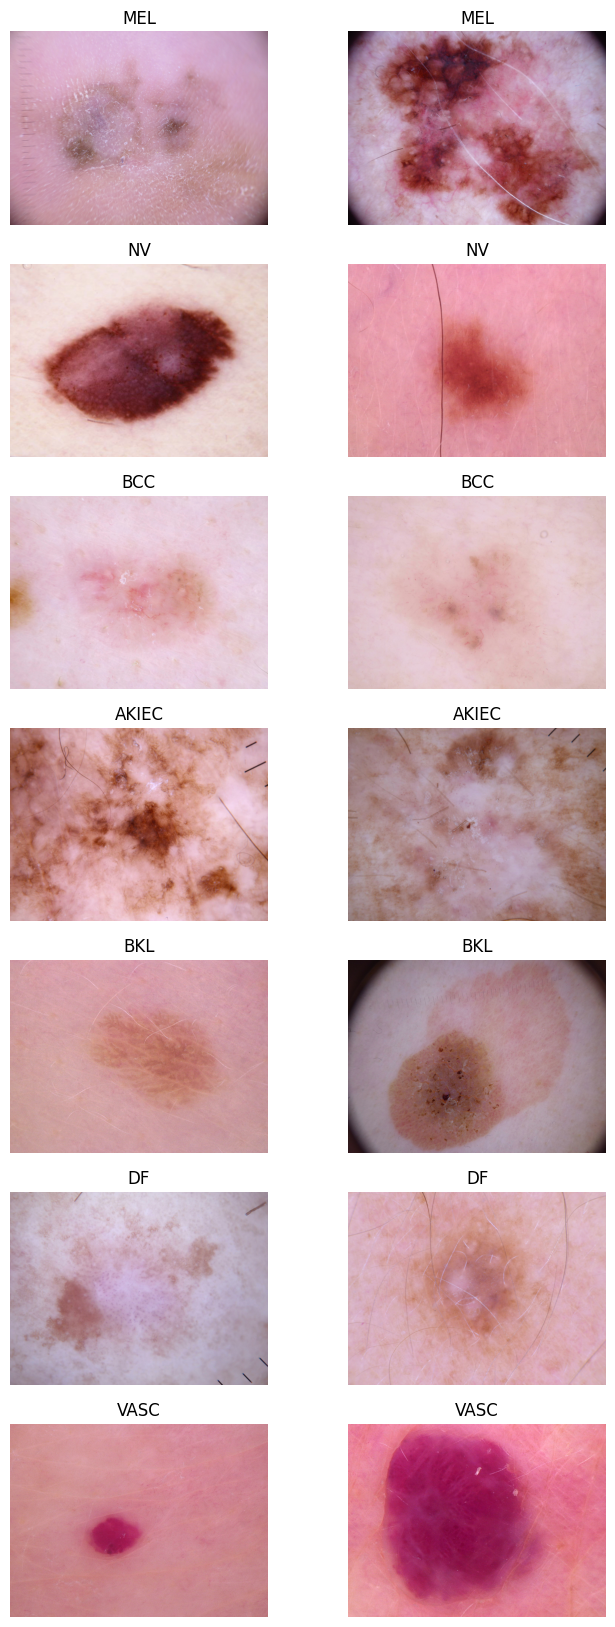

In [3]:
images, labels = [], []
for cls in range(train_dataset.num_classes):
    img_idx = train_dataset.targets.index(cls)
    img, target  = train_dataset[img_idx]
    images.append(img)
    labels.append(train_dataset.target_to_label[target])

    img_idx = train_dataset.targets.index(cls, img_idx+1)
    img, target  = train_dataset[img_idx]
    images.append(img)
    labels.append(train_dataset.target_to_label[target])

fig, axes = draw_samples(images, labels, 7, 2)
plt.show()

### 数据预处理
在实验中，我对训练数据集采取了如下的数据增广操作
- 随机左右翻转
- 随机上下翻转
- 随机旋转[-30deg,  30deg]
- 随机裁剪出大小为[224, 224]区域
- 转换成PyTorch使用的tensor形式
- 应用正则化

对验证集
- 最小边放缩至224
- 中心裁剪大小为[224, 224]的区域
- 转换成PyTorch使用的tensor形式
- 应用正则化

在评估的时候，训练、验证、测试集都使用了第二种处理方式

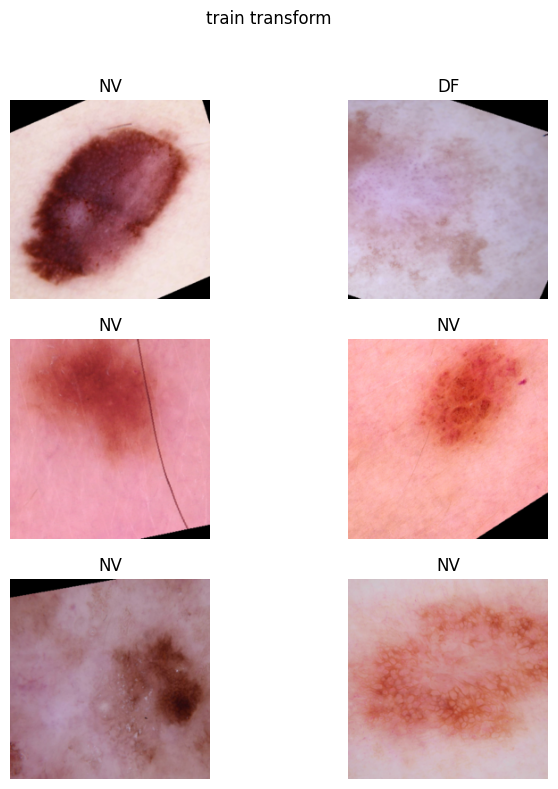

In [4]:

train_trans = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.4, 1), ratio=(3/4, 4/3)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_trans = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ISIC2018Dataset(
    csv_file_path='./data/ISIC2018/Train_GroundTruth.csv',
    img_dir='./data/ISIC2018/ISIC2018_Task3_Training_Input',
    transform=train_trans
)

valid_dataset = ISIC2018Dataset(
    csv_file_path='./data/ISIC2018/ISIC2018_Task3_Validation_GroundTruth.csv',
    img_dir='./data/ISIC2018/ISIC2018_Task3_Validation_Input',
    transform=test_trans
)

test_dataset = ISIC2018Dataset(
    csv_file_path='./data/ISIC2018/Test_GroundTruth.csv',
    img_dir='./data/ISIC2018/ISIC2018_Task3_Training_Input',
    transform=test_trans
)

train_iter = DataLoader(train_dataset,
                        batch_size=6)
valid_iter = DataLoader(valid_dataset,
                        batch_size=6)

images, labels = next(iter(train_iter))

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = [img.transpose((1, 2, 0)) for img in images.numpy()]
images = [np.clip(std*img+mean, 0, 1) for img in images]
labels = [train_dataset.target_to_label[i] for i in labels.numpy()]

fig, axes = draw_samples(images, labels, 3, 2, "train transform")
plt.show()

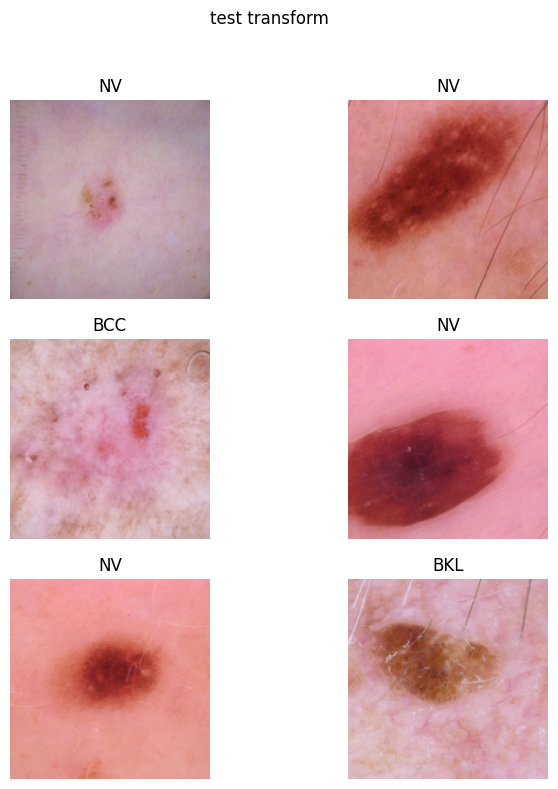

In [5]:
images, labels = next(iter(valid_iter))

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = [img.transpose((1, 2, 0)) for img in images.numpy()]
images = [np.clip(std*img+mean, 0, 1) for img in images]
labels = [train_dataset.target_to_label[i] for i in labels.numpy()]

fig, axes = draw_samples(images, labels, 3, 2, "test transform")
plt.show()